# turtle trading

- 가격이 마지막 window_size일 동안 최고 가격에 도달하면 롱 시그널(여기선 50)


In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import data
import matplotlib.pyplot as plt

In [2]:
def load_financial_data(start_date, end_date,output_file):
    df = data.DataReader('GOOG', 'yahoo', start_date, end_date)
    return df

goog_data=load_financial_data(start_date='2001-01-01',
                    end_date = '2021-01-01',
                    output_file='goog_data.pkl')

In [4]:
# 가격이 지난 window_size일의 이동 평균을 넘어서면 포지션 정리
def turtle_trading(financial_data, window_size):
    signals = pd.DataFrame(index=financial_data.index)
    signals['orders'] = 0
    # 고가에 대한 윈도우 크기
    signals['high'] = financial_data['Adj Close'].shift(1).\
        rolling(window=window_size).max()
    # 저가에 대한 윈도우 크기
    signals['low'] = financial_data['Adj Close'].shift(1).\
        rolling(window=window_size).min()
    # 평균에 대한 윈도우 크기
    signals['avg'] = financial_data['Adj Close'].shift(1).\
        rolling(window=window_size).mean()
    
    # 주가> window_size일에서 가장 높은값
    # 주가< window_size일에서 최저값

    signals['long_entry'] = financial_data['Adj Close'] > signals.high
    signals['short_entry'] = financial_data['Adj Close'] < signals.low

    # 청산규칙: 주가가 과거 window_size일의 평균을 교차할 때

    signals['long_exit'] = financial_data['Adj Close'] < signals.avg
    signals['short_exit'] = financial_data['Adj Close'] > signals.avg
    
    init=True
    position=0
    for k in range(len(signals)):
        if signals['long_entry'][k] and position==0:
            signals.orders.values[k] = 1
            position=1
        elif signals['short_entry'][k] and position==0:
            signals.orders.values[k] = -1
            position=-1
        elif signals['short_exit'][k] and position>0:
            signals.orders.values[k] = -1
            position = 0
        elif signals['long_exit'][k] and position < 0:
            signals.orders.values[k] = 1
            position = 0
        else:
            signals.orders.values[k] = 0

    return signals

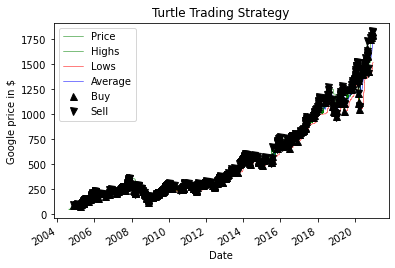

In [5]:
ts=turtle_trading(goog_data, 50)

fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel='Google price in $')
goog_data["Adj Close"].plot(ax=ax1, color='g', lw=.5)
ts["high"].plot(ax=ax1, color='g', lw=.5)
ts["low"].plot(ax=ax1, color='r', lw=.5)
ts["avg"].plot(ax=ax1, color='b', lw=.5)


ax1.plot(ts.loc[ts.orders== 1.0].index,
         goog_data["Adj Close"][ts.orders == 1.0],
         '^', markersize=7, color='k')

ax1.plot(ts.loc[ts.orders== -1.0].index,
         goog_data["Adj Close"][ts.orders == -1.0],
         'v', markersize=7, color='k')


#
# ax1.plot(ts.loc[ts.long_entry== True].index,
#          goog_data["Adj Close"][ts.long_entry== True],
#          '^', markersize=7, color='k')
#
# ax1.plot(ts.loc[ts.short_entry== True].index,
#          goog_data["Adj Close"][ts.short_entry== True],
#          'v', markersize=7, color='k')
#
# ax1.plot(ts.loc[ts.long_exit == True].index,
#          goog_data["Adj Close"][ts.long_exit == True],
#          'v', markersize=7, color='k')
#
# ax1.plot(ts.loc[ts.short_exit == True].index,
#          goog_data["Adj Close"][ts.short_exit == True],
#          'v', markersize=7, color='k')


plt.legend(["Price","Highs","Lows","Average","Buy","Sell"])
plt.title("Turtle Trading Strategy")

plt.show()

In [6]:
import sys
sys.exit(0)

# 초기자본설정
initial_capital = float(10000.0)

# 데이터프레임 포지션 만들기
positions = pd.DataFrame(index=signals.index).fillna(0.0)

# 신호 1일 때 MSFT 10개 매수
# 신호 -1일때 MSFT 10개 매도
# 데이터프레임에 할당
positions['MSFT'] = 10 * signals['signal']

# (quantity x price)계산
# 포트폴리오에 집어넣기
portfolio = positions.multiply(financial_data['Adj Close'], axis=0)

# 포트폴리오에 holdings 추가
portfolio['holdings'] = (positions.multiply(financial_data['Adj Close'], axis=0)).sum(axis=1)

# 차이를 저장
pos_diff = positions.diff()
# 포폴에 cash추가 (자본상태)
# 초기자본 - (매수매도에 사용될 값)
portfolio['cash'] = initial_capital - (pos_diff.multiply(financial_data['Adj Close'], axis=0)).sum(axis=1).cumsum()

# 계산
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# 수익률
portfolio['returns'] = portfolio['total'].pct_change()

print(portfolio)

SystemExit: 0

C:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3426: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
